<a href="https://colab.research.google.com/github/Sadhwika06/Fashion-Apparel-Classification-/blob/main/fashion_cnn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d "/content/fashion_data"




In [15]:
!ls /content/fashion_data


images	myntradataset  styles.csv


In [16]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [17]:
import pandas as pd

csv_path = '/content/fashion_data/styles.csv'

# Use on_bad_lines='skip' instead of error_bad_lines=False
df = pd.read_csv(csv_path, on_bad_lines='skip')

df.head()



,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [18]:
# Full robust training cell

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------ USER PARAMETERS ------------
CSV_PATH = "/content/fashion_data/styles.csv"
IMAGE_DIR = "/content/fashion_data/images"   # update if images in subfolder
TOP_N_CLASSES = 10         # pick top N classes to train on
SAMPLES_PER_CLASS = 500    # max images per class (reduce for speed)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 8
# -----------------------------------------

# 1) Load CSV (skip bad lines)
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
# Keep only relevant columns (adjust if different)
df = df[['id', 'articleType']].dropna()

# Make filename column
df['filename'] = df['id'].astype(str) + ".jpg"

# 2) Keep only rows whose image file actually exists
df['exists'] = df['filename'].apply(lambda f: os.path.exists(os.path.join(IMAGE_DIR, f)))
df = df[df['exists']].drop(columns='exists')
print("Total available images in CSV that exist on disk:", len(df))

# 3) Choose top N classes by frequency
top_classes = df['articleType'].value_counts().nlargest(TOP_N_CLASSES).index.tolist()
df = df[df['articleType'].isin(top_classes)].copy()
print("Selected classes:", top_classes)
print("Images after selecting top classes:", len(df))

# 4) (Optional) Limit SAMPLES_PER_CLASS for speed/balance
balanced = df.groupby('articleType').apply(
    lambda g: g.sample(n=min(len(g), SAMPLES_PER_CLASS), random_state=42)
).reset_index(drop=True)
df = balanced.sample(frac=1, random_state=42).reset_index(drop=True)   # shuffle
print("Images after balancing (max per class):", len(df))
print(df['articleType'].value_counts())

# 5) Stratified train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['articleType'])
print("Train size:", len(train_df), "Val size:", len(val_df))

# 6) Prepare ImageDataGenerator and flow_from_dataframe
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Important: set 'classes' explicitly so generators share same class-to-index mapping
# We'll pass class_mode='categorical' and supply the same class list order for both.
classes_list = top_classes  # fixed order

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='articleType',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes_list,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='articleType',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes_list,
    shuffle=False
)

# Confirm same number of classes
num_classes = len(train_gen.class_indices)
print("Number of classes (train):", num_classes)
print("Class indices mapping:", train_gen.class_indices)

# 7) Build the CNN model (use Input layer to avoid warning)
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 8) Train the model
steps_per_epoch = max(1, train_gen.samples // BATCH_SIZE)
validation_steps = max(1, val_gen.samples // BATCH_SIZE)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

# 9) Save model and display final eval
model.save("fashion_cnn_model.h5")
print("Saved model to fashion_cnn_model.h5")

loss, acc = model.evaluate(val_gen, steps=validation_steps)
print(f"Validation accuracy: {acc*100:.2f}%")


Total available images in CSV that exist on disk: 44419
Selected classes: ['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes', 'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses']
Images after selecting top classes: 25465
Images after balancing (max per class): 5000
articleType
Kurtas          500
Sports Shoes    500
Heels           500
Handbags        500
Casual Shoes    500
Shirts          500
Sunglasses      500
Tops            500
Watches         500
Tshirts         500
Name: count, dtype: int64
Train size: 4000 Val size: 1000
Found 4000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Number of classes (train): 10
Class indices mapping: {'Tshirts': 0, 'Shirts': 1, 'Casual Shoes': 2, 'Watches': 3, 'Sports Shoes': 4, 'Kurtas': 5, 'Tops': 6, 'Handbags': 7, 'Heels': 8, 'Sunglasses': 9}


/tmp/ipython-input-101000081.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced = df.groupby('articleType').apply(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,602 (24.87 MB)

 Trainable params: 6,518,602 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.2641 - loss: 2.0089 - val_accuracy: 0.6935 - val_loss: 0.9561
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.5701 - loss: 1.1223 - val_accuracy: 0.7692 - val_loss: 0.6484
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.6473 - loss: 0.9072 - val_accuracy: 0.7964 - val_loss: 0.5732
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.7093 - loss: 0.7663 - val_accuracy: 0.8014 - val_loss: 0.5687
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.7501 - loss: 0.6849 - val_accuracy: 0.8347 - val_loss: 0.5089
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7538 - loss: 0.6755 - val_accuracy: 0.8327 - val_loss: 0.4615
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.7680 - loss: 0.6178 - val_accuracy: 0.8246 - val_loss: 0.4833
Epoch 8/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.7816 - loss: 0.5858 - 

Saved model to fashion_cnn_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8398 - loss: 0.4561
Validation accuracy: 84.38%


Testing

In [19]:
!ls /content/drive/MyDrive | grep archive



archive.zip


In [20]:
model.save("/content/drive/MyDrive/fashion_cnn_model.h5")


Mounted at /content/drive
Found 4000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Num classes: 10
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 431ms/step - accuracy: 0.3193 - loss: 2.0237 - val_accuracy: 0.7722 - val_loss: 0.7452
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 379ms/step - accuracy: 0.7325 - loss: 0.7500 - val_accuracy: 0.8054 - val_loss: 0.5229
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.7937 - loss: 0.5683 - val_accuracy: 0.8044 - val_loss: 0.4783
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.8119 - loss: 0.5020 - val_accuracy: 0.8266 - val_loss: 0.4585
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8358 - loss: 0.4416 - val_accuracy: 0.8387 - val_loss: 0.4168
Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step - accuracy: 0.7521 - loss: 0.7038 - val_accuracy: 0.8216 - val_loss: 0.4599
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 378ms/step - accuracy: 0.8406 - loss: 0.4612 - val_accuracy: 0.8175 - val_loss: 0.4786
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 388ms/step - accuracy: 0.8456 - loss: 0.4397 - 

Saved transfer model to: /content/drive/MyDrive/fashion_mobilenetv2.h5


Loaded model for inference.

Now upload an image (single photo or group photo). After uploading, the code will test both modes:


Saving 8.jpeg to 8 (1).jpeg

== Processing: 8 (1).jpeg ==

Detected regions: 0


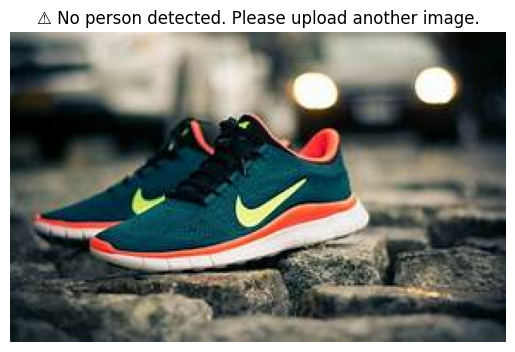

Falling back to whole-image classification.
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


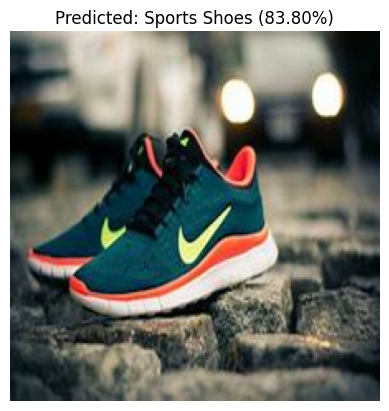

Top predictions:
  Sports Shoes: 83.80%
  Casual Shoes: 15.48%
  Heels: 0.58%


In [24]:
# ---- Transfer learning training + robust inference (single cell) ----
# Assumes you already have train_df, val_df, classes_list, IMAGE_DIR defined (from your earlier prep)
# If not, re-run the data-prep cell you used before to create those variables.

# 0) mount drive (if not already)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1) imports
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from google.colab import files
import os

# 2) hyperparams
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 5        # head training epochs (small)
EPOCHS_FINE = 3        # fine-tune epochs (optional)
LR_HEAD = 1e-4
LR_FINE = 1e-5

# 3) Recreate generators at 224x224 (will use your train_df / val_df and classes_list)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
    shear_range=0.1, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=IMAGE_DIR, x_col='filename', y_col='articleType',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    classes=classes_list, shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df, directory=IMAGE_DIR, x_col='filename', y_col='articleType',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical',
    classes=classes_list, shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Num classes:", num_classes)

# 4) Build MobileNetV2 transfer learning model
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)
tl_model = Model(inputs=base.input, outputs=preds)

# freeze base for head training
for layer in base.layers:
    layer.trainable = False

tl_model.compile(optimizer=Adam(learning_rate=LR_HEAD), loss='categorical_crossentropy', metrics=['accuracy'])
tl_model.summary()

# 5) Train head
steps_per_epoch = max(1, train_gen.samples // BATCH_SIZE)
validation_steps = max(1, val_gen.samples // BATCH_SIZE)
history_head = tl_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS_HEAD
)

# 6) Fine-tune: unfreeze last layers of base for small number of epochs
for layer in base.layers[-40:]:
    layer.trainable = True

tl_model.compile(optimizer=Adam(learning_rate=LR_FINE), loss='categorical_crossentropy', metrics=['accuracy'])
history_ft = tl_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS_FINE
)

# 7) Save model to Drive
save_path = "/content/drive/MyDrive/fashion_mobilenetv2.h5"
tl_model.save(save_path)
print("Saved transfer model to:", save_path)



Loaded model for inference.

Now upload an image (single photo or group photo). After uploading, the code will test both modes:


Saving 5.jpeg to 5 (1).jpeg

== Processing: 5 (1).jpeg ==

Detected regions: 0


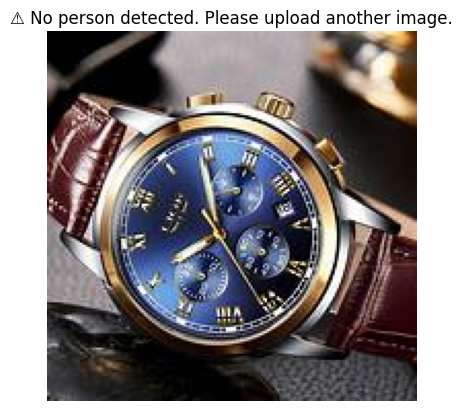

Falling back to whole-image classification.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


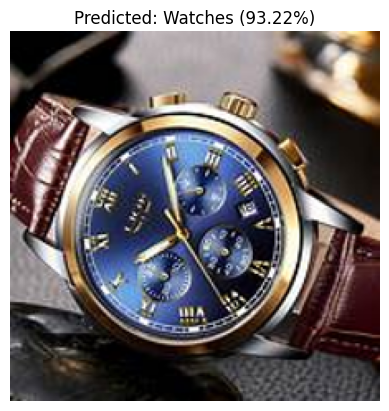

Top predictions:
  Watches: 93.22%
  Tshirts: 5.67%
  Handbags: 0.36%


In [31]:
# ------------------ Inference utilities ------------------

# load model (we already have tl_model in memory; but let's reload to simulate inference scenario)
model = tf.keras.models.load_model(save_path)
print("Loaded model for inference.")

# class labels in training order
class_labels = classes_list  # ensure this matches training order

# helper: show top-k and unknown handling
import math
TOP_K = 3
CONFIDENCE_THRESHOLD = 0.45   # tune this; above threshold considered confident

def predict_single_image(img_pil, show=True):
    # img_pil: PIL Image
    img = img_pil.convert('RGB').resize(IMG_SIZE)
    x = np.array(img)/255.0
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)[0]
    top_idx = preds.argsort()[-TOP_K:][::-1]
    top_probs = preds[top_idx]
    results = [(class_labels[i], float(top_probs[j])) for j,i in enumerate(top_idx)]
    if show:
        plt.imshow(img); plt.axis('off')
        if top_probs[0] < CONFIDENCE_THRESHOLD:
            plt.title(f"Prediction: Unknown (top {results[0][0]} {results[0][1]*100:.2f}%)")
        else:
            plt.title(f"Predicted: {results[0][0]} ({results[0][1]*100:.2f}%)")
        plt.show()
        print("Top predictions:")
        for lbl, p in results:
            print(f"  {lbl}: {p*100:.2f}%")
    return results

# group detection: detect people and classify each person crop
# uses HOG person detector (better than fullbody cascade for many photos)
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def predict_group_image(image_path, show=True):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: could not read image.")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rects, weights = hog.detectMultiScale(img_rgb, winStride=(8,8), padding=(8,8), scale=1.05)
    print("Detected regions:", len(rects))
    if len(rects) == 0:
        if show:
            plt.imshow(img_rgb); plt.axis('off'); plt.title("⚠️ No person detected. Please upload another image."); plt.show()
        return []
    out = img_rgb.copy()
    results_all = []
    for i, (x, y, w, h) in enumerate(rects):
        # expand box a little
        pad = int(0.05*min(w,h))
        x1, y1 = max(0, x-pad), max(0, y-pad)
        x2, y2 = min(out.shape[1], x+w+pad), min(out.shape[0], y+h+pad)
        crop = out[y1:y2, x1:x2]
        crop_pil = Image.fromarray(crop)
        preds = predict_single_image(crop_pil, show=False)
        label, prob = preds[0]  # top-1
        prob = float(prob)
        display_label = label if prob >= CONFIDENCE_THRESHOLD else "Unknown"
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(out, f"{display_label} ({prob*100:.1f}%)", (x1, max(y1-8,0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
        results_all.append({"box":(x1,y1,x2,y2), "label":display_label, "prob":prob})
    if show:
        plt.figure(figsize=(12,8)); plt.imshow(out); plt.axis('off'); plt.title("Detected People & Predictions"); plt.show()
    return results_all

# ------------------ Run inference interactively ------------------

print("\nNow upload an image (single photo or group photo). After uploading, the code will test both modes:")
uploaded = files.upload()

for fname in uploaded.keys():
    print("\n== Processing:", fname, "==\n")
    # First attempt: if there are people => run group detection
    group_results = predict_group_image(fname, show=True)
    # If no people found, fall back to whole-image classification:
    if not group_results:
        print("Falling back to whole-image classification.")
        try:
            pil = Image.open(fname)
            predict_single_image(pil, show=True)
        except Exception as e:
            print("Error predicting whole image:", e)

# ------------------ End of cell ------------------


In [32]:
# Install Git if needed
!apt-get install git -y

# Configure Git username & email (replace with your GitHub info)
!git config --global user.email "2310030184@klh.edu.in"
!git config --global user.name "Sadhwika06"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [33]:
!git clone https://github.com/Sadhwika06/Fashion-Apparel-Classification-.git

Cloning into 'Fashion-Apparel-Classification-'...


In [38]:
!pwd
!ls


/content
'1 (1).jpeg'   5.jpeg				 FashionApparelClassification
'1 (2).jpeg'  '8 (1).jpeg'			 fashion_cnn_model.h5
 1.jpeg       '8 (2).jpeg'			 fashion_data
 2.jpeg        8.jpeg				 sample_data
 3.jpeg        drive
'5 (1).jpeg'   Fashion-Apparel-Classification-


In [39]:
import os
print(os.getcwd())


/content
